## Case 1

### Data Analysis

In [1]:
#load in Case1Data.csv with pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Case1Data.csv')
#drop C_02 from data as 0 variance explained - 72.0 constant value
data = data.drop('C_02', axis=1)
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

data.head()

,y,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,...,x_90,x_91,x_92,x_93,x_94,x_95,C_01,C_03,C_04,C_05
0,375.823073,6.359019,-13.367120,-2.483750,-6.641891,11.733539,NaN,-17.085361,22.194764,16.827888,...,1.881514,-10.200888,3.980048,-4.433274,-1.473723,NaN,74.0,72.0,73.0,73.0
1,266.811730,3.873664,-8.470389,-3.055012,NaN,11.420983,1.822330,-13.694100,22.738654,20.307503,...,4.327449,-9.740207,NaN,-2.629314,4.816987,-12.240248,74.0,72.0,73.0,73.0
2,267.271759,5.275824,-12.070531,-1.366168,-4.819100,10.721527,-5.125992,-17.476865,NaN,15.963889,...,-5.345659,-14.501970,10.054005,NaN,NaN,-11.107921,73.0,75.0,74.0,74.0
3,219.951294,4.430110,-4.467975,-0.730736,-10.047104,11.498539,-2.870260,-14.033012,18.225190,10.409488,...,0.196925,-11.086963,2.019726,-8.531959,3.520833,NaN,71.0,73.0,71.0,72.0
4,289.697954,3.116458,-8.518713,-6.796050,NaN,7.646285,-3.118309,-13.102567,22.801217,16.680208,...,-0.474149,-9.117422,6.627601,-2.805531,5.914351,-11.240573,72.0,72.0,74.0,75.0


In [180]:
# print when a NaN value is found for each observation
print(data.isnull().sum(axis=1))


0     15
1     12
2     16
3     10
4     12
      ..
95    13
96    16
97     9
98    16
99    12
Length: 100, dtype: int64


Since there are missing values in more or less all observations, we need to find a smart way of filling them out - setting them to 0 is most likely too naive if we have highly correlating variables in dataset too.

In [123]:
np.unique(data.C_02)

array([72., nan])

In [6]:
## method 1 - use expected value imputation to fill in NaN values

#A matrix denoting if value is NaN
nan_matrix = np.isnan(X)

f_avg = np.asarray(np.mean(data,axis=0))[1:]
# if X[i] is NaN, replace with the average of the feature
for i in range(len(X)):
    for j in range(len(X[i])):
        if nan_matrix[i][j]:
            X[i][j] = f_avg[j] #slicing is better but this is easier to setup


In [ ]:
# # center the data to have mean 0 and variance 1
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# y = (y - np.mean(y)) / np.std(y)


In [ ]:
## method 2 - Use linear regression to fill in missing values

## ASK TA WHY THIS DOESN'T WORK
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Sample Data
np.random.seed(42)

# Step 1: Store NaN locations
nan_matrix = np.isnan(X)

# Step 2: Fill NaNs with column averages
column_means = np.nanmean(X, axis=0)
X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])  # Efficient column-wise assignment

# Step 3: Train linear regression models and predict missing values
for i in range(X.shape[1]):
    # Split data into missing and non-missing values
    missing = nan_matrix[:, i]
    present = ~missing

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X[present], y[present])

    # Predict missing values
    X_missing = X[missing]
    X[missing, i] = model.predict(X_missing)
# Convert back to DataFrame
df_filled = pd.DataFrame(X, columns=data.columns.drop('y'))

In [ ]:
# Display results
#check if there are any NaN values
print(df_filled.isnull().sum(axis=1))

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Length: 100, dtype: int64


In [183]:
X_train.shape

(80, 99)

In [187]:
#linear regression model to predict y from X
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

print(y_test)
print(y_pred)

1202.22718978639
[270.63620333  58.90373876 248.2937335  134.31305932 186.77032495
 155.32227947 235.00234276 284.45597869 260.27416868 375.82307301
 231.41466141 194.53679993  39.7022177  263.82929181 165.43351739
 289.69795389 219.66758656 141.18055872 106.47855156 163.8758382 ]
[226.50937798  77.79333192 293.93526992 134.73671693 236.12148237
 128.84643279 257.4949094  300.87038127 221.22532439 353.19990401
 209.93398444 198.85579879 109.38629142 269.86288407 204.68828206
 305.43990925 212.56055145 204.83406479 153.90493185 149.87183868]


In [155]:
# SVM model to predict y from X
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


6707.03886445971


In [108]:
#load in Xnew.csv
data_new = pd.read_csv('Case1Data_Xnew.csv')
X_new = np.array(data_new)

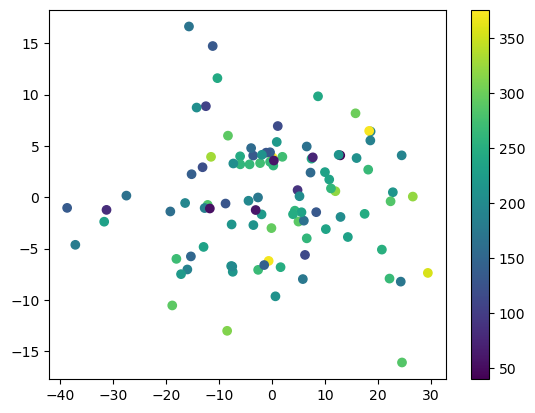

In [189]:
# visualize the data using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.colorbar()
plt.show()

In [ ]:
#polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(4), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


In [92]:
class RLSLasso:
    """
    Recursive Least Squares (RLS) with L1 regularization (LASSO).
    
    This class performs an online (incremental) update of regression weights.
    """

    def __init__(self, alpha=0.35, lambda_rls=1.0):
        self.alpha = alpha  # L1 regularization strength (like Lasso)
        self.lambda_rls = lambda_rls  # RLS regularization (prevents instability)
        self.P = None  # Inverse covariance matrix
        self.w = None  # Model coefficients

    def fit(self, X, y):
        """Batch training for initialization"""
        n_samples, n_features = X.shape
        self.P = np.eye(n_features) / self.lambda_rls
        self.w = np.zeros(n_features)

        for i in range(n_samples):
            self.partial_fit(X[i].reshape(1, -1), np.array([y[i]]))  # Update weights iteratively
    
    def partial_fit(self, X_new, y_new):
        """Online update using RLS with L1 shrinkage"""
        for i in range(X_new.shape[0]):
            x_t = X_new[i].reshape(-1, 1)  # Column vector
            y_t = y_new[i]
            
            # Kalman gain
            Px = self.P @ x_t
            gain = Px / (1 + x_t.T @ Px)

            # Standard RLS update
            self.w += gain.flatten() * (y_t - x_t.T @ self.w)

            # Apply L1 shrinkage (soft thresholding)
            self.w = np.sign(self.w) * np.maximum(np.abs(self.w) - self.alpha, 0)

            # Update P
            self.P = self.P - gain @ Px.T

    def predict(self, X):
        """Predict using learned weights"""
        return X @ self.w

In [96]:
# Wrapper for experiment
from sklearn.model_selection import train_test_split

#import model classes from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
#elastic net
from sklearn.linear_model import ElasticNet
#PCA
from sklearn.decomposition import PCA
#PLS
from sklearn.cross_decomposition import PLSRegression

def run_experiment(X_nan, y, model_class="linear_regression", *args, **kwargs):
    """
    Wrapper function to run an experiment.
    
    Parameters:
    X : array-like
        Feature matrix.
    y : array-like
        Target vector.
    model_class : class
        Model class (e.g., sklearn's classifiers like RandomForestClassifier).
    *args : tuple
        Positional arguments to pass to the model constructor.
    **kwargs : dict
        Keyword arguments to pass to the model constructor.
    
    Returns:
    dict
        A dictionary with model, predictions, and accuracy.
    """
    X = fill_nan(X_nan, method='mean')
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize model
    if model_class == "linear_regression":
        model = LinearRegression()
    elif model_class == "svm":
        model = SVR()
    elif model_class == "random_forest":
        model = RandomForestClassifier()
    elif model_class == "polynomial_regression":
        model = make_pipeline(PolynomialFeatures(*args), LinearRegression())
    elif model_class == "ridge_regression":
        model = Ridge()
    elif model_class == "lasso":
        model = Lasso(alpha=0.35)
    elif model_class == "rls_lasso": # rls good for sequential data, not good in this use case
        model = RLSLasso(alpha=0.0001,lambda_rls=10)
    elif model_class == "elastic_net":
        model = ElasticNet(alpha=0.3,l1_ratio=0.85)
    elif model_class == "PCR":
        model = make_pipeline(PCA(n_components=20), LinearRegression())
    elif model_class == "PLS":
        model = PLSRegression(n_components=40,max_iter=10000)
    else:
        raise ValueError("Invalid model class")


    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        "model": model,
        "predictions": y_pred,
        "RMSE": RMSE
    }

#run with ridge

print(run_experiment(X,y,model_class="ridge_regression"))
print(run_experiment(X,y,model_class="linear_regression"))
#print(run_experiment(X,y,model_class="polynomial_regression"), 16)
#print(run_experiment(X,y,model_class="svm"))
print(run_experiment(X,y,model_class="lasso"))
print(run_experiment(X,y,model_class="elastic_net"))
print(run_experiment(X,y,model_class="PLS"))



{'model': Ridge(), 'predictions': array([226.73862923,  75.81835163, 292.34619295, 125.86609104,
       229.11957405, 128.1303316 , 258.06330908, 289.3606733 ,
       220.28971578, 343.84199623, 210.24203943, 191.12415958,
       108.2989197 , 267.72115221, 201.3183806 , 301.07733222,
       221.74964282, 198.55272394, 149.63754477, 155.24549152]), 'RMSE': 32.989557547937494}
{'model': LinearRegression(), 'predictions': array([226.95749463,  77.75054085, 293.78413701, 134.48356412,
       236.36680985, 128.95516229, 257.49785841, 301.16627724,
       221.14393782, 353.19427707, 210.01150198, 199.00498787,
       109.56325915, 269.68269049, 204.56340689, 305.36302255,
       212.63931337, 204.96932692, 153.91096723, 149.92293482]), 'RMSE': 34.675888149474346}
{'model': Lasso(alpha=0.35), 'predictions': array([224.2822175 ,  66.23287356, 284.56706125, 124.3758193 ,
       217.60595701, 135.43840054, 252.80746505, 267.19272891,
       216.15603068, 335.3238944 , 238.09062741, 188.62660959

In [ ]:
#load in Case1Data.csv with pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Case1Data.csv')
#drop C_02 from data as 0 variance explained - 72.0 constant value
data = data.drop('C_02', axis=1)
y = np.array(data['y'])
X_nan = np.array(data.drop('y', axis=1))

from sklearn.linear_model import LinearRegression
def fill_nan(X, method='mean'):
    """"
    "Fill NaN values in a 2D array using the specified method""
    """
    if method == 'mean':
        column_means = np.nanmean(X, axis=0)
        nan_matrix = np.isnan(X)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])
    elif method == 'regression':
        nan_matrix = np.isnan(X)
        # Step 2: Fill NaNs with column averages
        column_means = np.nanmean(X, axis=0)
        X[nan_matrix] = np.take(column_means, np.where(nan_matrix)[1])  # Efficient column-wise assignment

        # Step 3: Train linear regression models and predict missing values
        for col in range(X.shape[1]):  
            missing_rows = np.where(nan_matrix[:, col])[0]  # Indices of missing values in this column
            
            if len(missing_rows) > 0:  # Only train if there were NaNs
                # Compute correlation, handle constant columns
                corr_matrix = np.corrcoef(X.T)
                corr_matrix = np.nan_to_num(corr_matrix)  # Replace NaNs/Infs with 0

                # Sort and select the 5 most correlated columns (excluding itself)
                correlation = np.abs(corr_matrix[col])
                sorted_indices = np.argsort(-correlation)  # Sort descending
                correlated_indices = [idx for idx in sorted_indices if idx != col][:5]  # Exclude itself

                # Ensure no NaNs in selected correlated columns
                valid_rows = ~np.any(nan_matrix[:, correlated_indices], axis=1)
                X_train, y_train = X[valid_rows][:, correlated_indices], X[valid_rows][:, col]

                if len(X_train) > 0:  # Ensure we have valid training data
                    # Train Linear Regression Model
                    model = LinearRegression()
                    model.fit(X_train, y_train)

                    # Predict missing values using the trained model
                    X_test = X[missing_rows][:, correlated_indices]
                    X[missing_rows, col] = model.predict(X_test)

    return X


X = fill_nan(X_nan, method='mean')


In [2]:
import numpy as np
import wandb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Initialize W&B project
#wandb.init(project="comptools-case1")

wandb.init(mode="offline")

# Generate synthetic data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective functions


def objective_elasticnet():
    # Access hyperparameters from wandb.config
    alpha = wandb.config.alpha
    l1_ratio = wandb.config.l1_ratio

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"neg_root_mean_mse": mean_score})  # Log only the target metric

    return mean_score




def objective_ridge():
    config = wandb.config
    model = Ridge(alpha=config.parameters.alpha, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"alpha": config.alpha, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_lasso():
    config = wandb.config
    model = Lasso(alpha=config.alpha, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"alpha": config.alpha, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_rf():
    config = wandb.config
    model = RandomForestRegressor(n_estimators=int(config.n_estimators), max_depth=int(config.max_depth), random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"n_estimators": config.n_estimators, "max_depth": config.max_depth, "neg_root_mean_mse": mean_score})
    return mean_score


def objective_svr():
    config = wandb.config
    model = SVR(C=config.C, epsilon=config.epsilon)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"C": config.C, "epsilon": config.epsilon, "neg_root_mean_mse": mean_score})
    return mean_score

# # W&B Hyperparameter Optimization
# sweep_config = {
#     "method": "bayes",
#     "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
#     "parameters": {
#         "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
#         "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
#         "n_estimators": {"min": 10, "max": 200},
#         "max_depth": {"min": 1, "max": 10},
#         "C": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
#         "epsilon": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"}
#     }
# }

# W&B Hyperparameter Optimization
sweep_config = {
    "method": "bayes",
    "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
        "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
    }
}
sweep_id = wandb.sweep(sweep_config, project="comptools-case1-")

# Run optimization for different models
wandb.agent(sweep_id, function=objective_elasticnet, count=20)
# wandb.agent(sweep_id, function=objective_ridge, count=20)
# wandb.agent(sweep_id, function=objective_lasso, count=20)
# wandb.agent(sweep_id, function=objective_rf, count=20)
# wandb.agent(sweep_id, function=objective_svr, count=20)

print("Optimization completed!")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: w535epah
Sweep URL: https://wandb.ai/otovo-dtu-qa/comptools-case1-/sweeps/w535epah


wandb: Agent Starting Run: s2d31ujc with config:
wandb: 	alpha: 0.013243320458774428
wandb: 	l1_ratio: 0.9226650506412712
Exception in thread Thread-11 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_15804\177237783.py", line 23, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise Att

Optimization completed!
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x0000017375C347D0>> (for post_run_cell), with arguments args (<ExecutionResult object at 17372b11100, execution_count=2 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1736c962750, raw_cell="import numpy as np
import wandb
from sklearn.model.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X24sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [2]:
import wandb
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import wandb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# Generate synthetic data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective_elasticnet():
    print(wandb.config)
    alpha = wandb.config.alpha
    l1_ratio = wandb.config.l1_ratio

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.sqrt(-np.mean(scores))
    wandb.log({"neg_root_mean_mse": mean_score})

    return mean_score

sweep_config = {
    "method": "bayes",
    "metric": {"name": "neg_root_mean_mse", "goal": "minimize"},
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
        "l1_ratio": {"min": 0, "max": 1, "distribution": "uniform"},
    }
}

# Initialize wandb BEFORE sweep and agent
wandb.init(project="comptools-case1-")

sweep_id = wandb.sweep(sweep_config, project="comptools-case1-")

wandb.agent(sweep_id, function=objective_elasticnet, count=20)

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kahmadi (otovo-dtu-qa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: i96c09ju
Sweep URL: https://wandb.ai/otovo-dtu-qa/comptools-case1-/sweeps/i96c09ju


wandb: Agent Starting Run: 0wsy3q2l with config:
wandb: 	alpha: 0.07616873860994129
wandb: 	l1_ratio: 0.4959325934003874
Exception in thread Thread-12 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^

{}


^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyke

{}


^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyker

{}


^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ip

{}


^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-pa

{}


^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ip

{}


^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipyk

{}


^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipykernel

{}


^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipykernel

{}


^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_3876\3935278225.py", line 18, in objective_elasticnet
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\khali\miniconda3\Lib\site-packages\ipy

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DA5E76E7E0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1da567e2f90, execution_count=2 error_before_exec=None error_in_exec=[WinError 10053] An established connection was aborted by the software in your host machine info=<ExecutionInfo object at 1da567e3200, raw_cell="import wandb
import numpy as np
from sklearn.linea.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X35sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [2]:
import wandb
import time
def test_config():
    time.sleep(0.5)  # Add a 0.5-second delay

    print(f"config: {wandb.config}")
    print(f"alpha: {wandb.config.alpha}")

sweep_config = {
    "method": "bayes",
    "metric": {  # Added metric section
        "name": "loss",  # Replace "loss" with your actual metric name
        "goal": "minimize"  # Or "maximize", depending on your metric
    },
    "parameters": {
        "alpha": {"min": 1e-4, "max": 1e1, "distribution": "log_uniform_values"},
    }
}
wandb.run=None
wandb.init(project="test_config_simple")
sweep_id = wandb.sweep(sweep_config, project="test_config_simple")
wandb.agent(sweep_id, function=test_config, count=3)
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000191BFB195B0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 191bfea9ca0, raw_cell="import wandb
import time
def test_config():
    ti.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X34sZmlsZQ%3D%3D>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: uwahtq2n
Sweep URL: https://wandb.ai/otovo-dtu-qa/test_config_simple/sweeps/uwahtq2n


wandb: Agent Starting Run: ayjqx2gr with config:
wandb: 	alpha: 0.11390880406490515


config: {}


Exception in thread Thread-16 (_run_job):
Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'alpha'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\khali\AppData\Local\Temp\ipykernel_11764\2916602097.py", line 7, in test_config
  File "c:\Users\khali\miniconda3\Lib\site-packages\wandb\sdk\wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'alpha'

During handling of the above 

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000191BFB195B0>> (for post_run_cell), with arguments args (<ExecutionResult object at 191bfea93d0, execution_count=2 error_before_exec=None error_in_exec=[WinError 10053] An established connection was aborted by the software in your host machine info=<ExecutionInfo object at 191bfea9ca0, raw_cell="import wandb
import time
def test_config():
    ti.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/khali/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/Kandidat/4.%20semester/02582_CDA/case1.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine